In [34]:
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [35]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cuda - Tesla P100-PCIE-16GB


In [37]:
'''import os
import csv

def create_emotion_csv_from_source(source_directory, output_csv):
    # Mapping of emotion codes to their corresponding folder names
    emotion_map = {
        'W': 'anger',
        'L': 'boredom',
        'E': 'disgust',
        'A': 'anxiety',
        'F': 'happiness',
        'T': 'sadness',
        'N': 'neutral'
    }

    # Open CSV file for writing
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Emotion', 'Path'])  # CSV header

        # Iterate through each file in the source directory
        for filename in os.listdir(source_directory):
            if filename.endswith('.wav') and len(filename) > 5:  # Check if it's a valid .wav file
                emotion_code = filename[5]  # Extract the emotion code from the filename
                emotion_folder = emotion_map.get(emotion_code)

                if emotion_folder:
                    # Construct the file path
                    file_path = os.path.join(source_directory, filename)
                    # Write the emotion and file path to the CSV
                    writer.writerow([emotion_folder, file_path])
                    #print(f'Added {filename} to CSV under emotion: {emotion_folder}')
                else:
                    print(f'Unknown emotion code "{emotion_code}" in file {filename}')
            else:
                print(f'Filename {filename} is too short or not a .wav file.')

# Usage example
source_dir = '/kaggle/input/berlin-database-of-emotional-speech-emodb/wav'  # Source directory containing .wav files
output_csv = '/kaggle/working/Emodb.csv'  # Path to the output CSV file
create_emotion_csv_from_source(source_dir, output_csv)
'''

'import os\nimport csv\n\ndef create_emotion_csv_from_source(source_directory, output_csv):\n    # Mapping of emotion codes to their corresponding folder names\n    emotion_map = {\n        \'W\': \'anger\',\n        \'L\': \'boredom\',\n        \'E\': \'disgust\',\n        \'A\': \'anxiety\',\n        \'F\': \'happiness\',\n        \'T\': \'sadness\',\n        \'N\': \'neutral\'\n    }\n\n    # Open CSV file for writing\n    with open(output_csv, mode=\'w\', newline=\'\') as file:\n        writer = csv.writer(file)\n        writer.writerow([\'Emotion\', \'Path\'])  # CSV header\n\n        # Iterate through each file in the source directory\n        for filename in os.listdir(source_directory):\n            if filename.endswith(\'.wav\') and len(filename) > 5:  # Check if it\'s a valid .wav file\n                emotion_code = filename[5]  # Extract the emotion code from the filename\n                emotion_folder = emotion_map.get(emotion_code)\n\n                if emotion_folder:\n

In this demonstration, I am only choosing 4 emotions, neutral, happy, sad and angry.

In [43]:
import pandas as pd
ravdess= pd.read_csv("/kaggle/input/ravdess-df/ravdess_df.csv")
ravdess.rename(columns={'Emotions': 'Emotion'}, inplace=True)


In [47]:
unique_emo = ravdess['Emotion'].unique()
print("Unique emotions:", unique_emo)

Unique emotions: ['neutral' 'disgust' 'fear' 'sad' 'happy' 'angry']


In [44]:
ravdess.head(10)

,Emotion,Path
0,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
1,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
4,fear,/kaggle/input/ravdess-emotional-speech-audio/a...
5,sad,/kaggle/input/ravdess-emotional-speech-audio/a...
6,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
7,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
8,happy,/kaggle/input/ravdess-emotional-speech-audio/a...
9,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...


In [48]:
ravdess = ravdess[(ravdess["Emotion"] == "neutral") | 
              (ravdess["Emotion"] == "happy") | 
              (ravdess["Emotion"] == "sad") | 
              (ravdess["Emotion"] == "angry")]


In [49]:
train_df = emodb.sample(frac=0.8)
test_df = emodb.drop(train_df.index)

### 2.2 Tokenization

In [50]:
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

def map_to_array(example):
    speech, _ = librosa.load(example["Path"], sr=16000, mono=True)
    example["speech"] = speech
    return example

train_data = Dataset.from_pandas(train_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

Map:   0%|          | 0/271 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

In [51]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        pattern = {
            'neutral': 0,
            'happiness': 1,
            'sadness': 2,
            'anger': 3,
        }
        self.labels = [pattern[x] for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmotionDataset(train_encodings, list(train_data["Emotion"]))
test_dataset = EmotionDataset(test_encodings, list(test_data["Emotion"]))

## 3. Loading the Model and Optimizer 

In [52]:
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
model.to(device)

optim = AdamW(model.parameters(), lr=1e-5)

In [53]:
print(set(train_data["Emotion"]))
print(set(test_data["Emotion"]))

{'sadness', 'anger', 'happiness', 'neutral'}
{'happiness', 'anger', 'sadness', 'neutral'}


In [54]:
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

In [55]:
'''from torch.utils.data import DataLoader
epoch = 20

model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        predictions = predict(outputs)

        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
        
        epoch_loss.append(loss.item())
        
    pbar.close()    
    train_loss += epoch_loss
    train_accuracies.append(accuracy)'''

Epoch 1/20


100%|██████████| 136/136 [00:58<00:00,  2.33it/s, Loss=0.474, Accuracy=0.435]


Epoch 2/20


100%|██████████| 136/136 [00:58<00:00,  2.32it/s, Loss=2.317, Accuracy=0.631]


Epoch 3/20


100%|██████████| 136/136 [00:59<00:00,  2.30it/s, Loss=0.164, Accuracy=0.734]


Epoch 4/20


100%|██████████| 136/136 [00:59<00:00,  2.29it/s, Loss=0.499, Accuracy=0.804]


Epoch 5/20


100%|██████████| 136/136 [00:59<00:00,  2.30it/s, Loss=1.551, Accuracy=0.815]


Epoch 6/20


100%|██████████| 136/136 [00:59<00:00,  2.30it/s, Loss=0.546, Accuracy=0.911]


Epoch 7/20


100%|██████████| 136/136 [00:59<00:00,  2.30it/s, Loss=0.017, Accuracy=0.889]


Epoch 8/20


100%|██████████| 136/136 [00:59<00:00,  2.30it/s, Loss=0.002, Accuracy=0.911]


Epoch 9/20


100%|██████████| 136/136 [00:59<00:00,  2.29it/s, Loss=0.443, Accuracy=0.904]


Epoch 10/20


100%|██████████| 136/136 [00:59<00:00,  2.30it/s, Loss=0.001, Accuracy=0.919]


Epoch 11/20


100%|██████████| 136/136 [00:59<00:00,  2.29it/s, Loss=0.001, Accuracy=0.930]


Epoch 12/20


100%|██████████| 136/136 [00:59<00:00,  2.30it/s, Loss=0.117, Accuracy=0.934]


Epoch 13/20


100%|██████████| 136/136 [00:59<00:00,  2.30it/s, Loss=0.022, Accuracy=0.948]


Epoch 14/20


100%|██████████| 136/136 [00:58<00:00,  2.31it/s, Loss=0.000, Accuracy=0.970]


Epoch 15/20


100%|██████████| 136/136 [00:59<00:00,  2.29it/s, Loss=0.003, Accuracy=0.959]


Epoch 16/20


100%|██████████| 136/136 [00:58<00:00,  2.32it/s, Loss=0.161, Accuracy=0.956]


Epoch 17/20


100%|██████████| 136/136 [00:59<00:00,  2.30it/s, Loss=0.001, Accuracy=0.967]


Epoch 18/20


100%|██████████| 136/136 [00:59<00:00,  2.30it/s, Loss=0.398, Accuracy=0.956]


Epoch 19/20


100%|██████████| 136/136 [00:59<00:00,  2.29it/s, Loss=0.134, Accuracy=0.967]


Epoch 20/20


100%|██████████| 136/136 [00:59<00:00,  2.30it/s, Loss=0.014, Accuracy=0.989]


In [62]:
import os
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

checkpoint_path = '/kaggle/working/model_20_ravdess.pth'

if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Loaded model weights from '{checkpoint_path}'")

model.train()

epoch = 5
train_loss = []
train_accuracies = []

for epoch_i in range(epoch):
    print(f'Epoch {epoch_i + 1}/{epoch}')
    time.sleep(0.3)
    
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    correct = 0
    count = 0
    epoch_loss = []
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        loss.backward()
        optim.step()
        
        predictions = predict(outputs) 
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct / count
        pbar.set_postfix({'Loss': f'{loss.item():.3f}', 'Accuracy': f'{accuracy:.3f}'})
        
        epoch_loss.append(loss.item())
    
    pbar.close()
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Loaded model weights from '/kaggle/working/model_20_ravdess.pth'
Epoch 1/5


100%|██████████| 136/136 [00:58<00:00,  2.32it/s, Loss=0.001, Accuracy=0.985]


Epoch 2/5


100%|██████████| 136/136 [00:58<00:00,  2.33it/s, Loss=0.000, Accuracy=0.948]


Epoch 3/5


100%|██████████| 136/136 [00:58<00:00,  2.32it/s, Loss=0.000, Accuracy=0.978]


Epoch 4/5


100%|██████████| 136/136 [00:59<00:00,  2.29it/s, Loss=0.019, Accuracy=0.959]


Epoch 5/5


100%|██████████| 136/136 [00:58<00:00,  2.32it/s, Loss=0.013, Accuracy=0.978]


In [67]:
torch.save(model.state_dict(), '/kaggle/working/model_25_ravdess.pth')

In [68]:
print("input_ids shape:", input_ids.shape)
print("attention_mask shape:", attention_mask.shape)
print("labels shape:", labels.shape)

input_ids shape: torch.Size([1, 87957])
attention_mask shape: torch.Size([1, 87957])
labels shape: torch.Size([1])


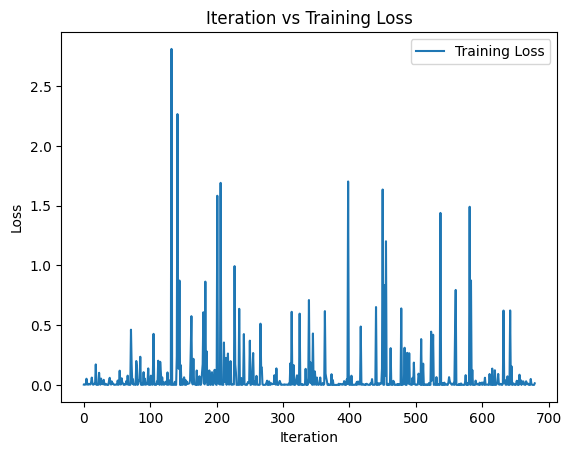

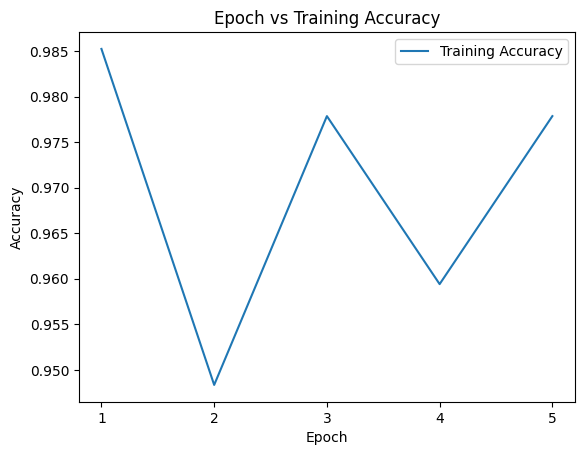

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1                          
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

Test the model.

In [70]:
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()

with torch.no_grad():
    
    correct = 0
    count = 0
    record = {"labels": list(), "predictions": list()}
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        predictions = predict(outputs)
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
        
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy * 100, 4))

print("\nClassification Report:")
print(classification_report(record["labels"], record["predictions"], digits=4))

100%|██████████| 68/68 [00:03<00:00, 17.62it/s, loss=0.000, accuracy=0.926]


The final accuracy on the test dataset: 92.6471%

Classification Report:
              precision    recall  f1-score   support

           0     0.7895    1.0000    0.8824        15
           1     0.9286    1.0000    0.9630        13
           2     1.0000    0.9286    0.9630        14
           3     1.0000    0.8462    0.9167        26

    accuracy                         0.9265        68
   macro avg     0.9295    0.9437    0.9312        68
weighted avg     0.9399    0.9265    0.9275        68



Check the result.

In [71]:
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

def get_emotion(label_id):
    return model.config.id2label[label_id]
    
df_record["Ground Truth"] = df_record.apply(lambda x: get_emotion(x["Ground Truth"]), axis=1)
df_record["Model Prediction"] = df_record.apply(lambda x: get_emotion(x["Model Prediction"]), axis=1)

df = pd.concat([test_df.reset_index(), df_record["Model Prediction"]], axis=1)
df["Emotion"] = df.apply(lambda x: x["Emotion"][:3], axis=1)

df[df["Emotion"]!=df["Model Prediction"]]

,index,Emotion,Path,Model Prediction
0,7,sad,/kaggle/input/berlin-database-of-emotional-spe...,ang
1,12,ang,/kaggle/input/berlin-database-of-emotional-spe...,sad
3,22,ang,/kaggle/input/berlin-database-of-emotional-spe...,sad
5,31,ang,/kaggle/input/berlin-database-of-emotional-spe...,sad
7,35,sad,/kaggle/input/berlin-database-of-emotional-spe...,ang
8,44,ang,/kaggle/input/berlin-database-of-emotional-spe...,sad
9,46,ang,/kaggle/input/berlin-database-of-emotional-spe...,sad
10,50,ang,/kaggle/input/berlin-database-of-emotional-spe...,sad
12,61,ang,/kaggle/input/berlin-database-of-emotional-spe...,hap
14,75,ang,/kaggle/input/berlin-database-of-emotional-spe...,neu


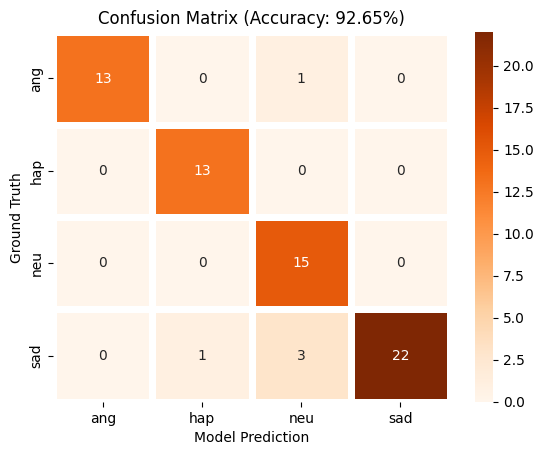

In [72]:
import seaborn as sns
crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()

In [ ]:
#emodb
# 92.65 on 20
# 95.59 on 25

In [ ]:
#ravdess
